In [500]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightComponents.Control
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using UnPack
using ControlSystems
using RobustAndOptimalControl

In [831]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#same mass in all cases
fwd_cg_pld = C172.PayloadU(m_pilot = 100, m_copilot = 100, m_baggage = 0)
aft_cg_pld = C172.PayloadU(m_pilot = 50, m_copilot = 50, m_baggage = 100)
mid_cg_pld = C172.PayloadU(m_pilot = 75, m_copilot = 75, m_baggage = 50)

design_condition_1 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 25.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 1.0,
    payload = mid_cg_pld)

design_condition_2 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 55.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 0.0,
    payload = mid_cg_pld)

ail_rud_MIMO = named_ss(ac, design_condition_1; model = :lat);
ail_rud_MIMO

NamedStateSpace{Continuous, Float64}
A = 
 -5.1863353105447745       2.5571504706211035   -1.4940496395721148e-5   -8.412643903721317e-8    0.021208552272927967    -0.20927207299819522      0.0                 0.0                  4.015429907016977      0.0                 -0.3593450108796908
 -0.10965700655715027     -0.6145184249254187    2.7868529475227888e-6   -2.242321214485088e-6    0.0022260644798630515    0.06398864887796041      0.0                 0.0                 -0.09629816687604409    0.0                  0.3613947924611671
  1.0                      0.2461249217794798   -6.822997012730885e-9     2.8548808637156386e-8   1.602621845881149e-18   -1.6143782896245511e-7    0.0                 0.0                  0.0                    0.0                  0.0
  0.0                      1.0298367984946242   -4.023279493220938e-6     6.822996860046383e-9    6.705696269384723e-18   -3.8582689039415235e-8    0.0                 0.0                  0.0                    0.0  

## 1. Roll Rate

In [832]:
P_a2p = ail_rud_MIMO[:p, :aileron_cmd]
zeros_p = zpkdata(P_a2p)[1][1]
ωn_p, ζ_p, poles_p = damp(P_a2p)
zeros_p |> display
poles_p |> display
ωn_p |> display
ζ_p |> display

5-element Vector{ComplexF64}:
    -0.3591864058923823 + 1.209180528777049im
    -0.3591864058923823 - 1.209180528777049im
    0.08658681162468258 + 0.0im
    -0.6229965628393609 + 0.0im
 -1.1265658245284408e-7 + 0.0im

11-element Vector{ComplexF64}:
 -1.8713534455024872e-5 + 0.0im
    0.09943760778084651 + 0.0im
    -0.6238772285264461 + 0.0im
    -0.4997568330301104 + 1.42036470780857im
    -0.4997568330301104 - 1.42036470780857im
     -5.106472163845825 + 0.0im
     -18.84955592153876 + 25.13274122871835im
     -18.84955592153876 - 25.13274122871835im
     -18.84955592153876 + 25.13274122871835im
     -18.84955592153876 - 25.13274122871835im
     -50.00000000000001 + 0.0im

11-element Vector{Float64}:
  1.8713534455024872e-5
  0.09943760778084651
  0.6238772285264461
  1.5057200255520313
  1.5057200255520313
  5.106472163845825
 31.415926535897935
 31.415926535897935
 31.415926535897935
 31.415926535897935
 50.00000000000001

11-element Vector{Float64}:
  1.0
 -1.0
  1.0
  0.33190554986933135
  0.33190554986933135
  1.0
  0.5999999999999999
  0.5999999999999999
  0.5999999999999999
  0.5999999999999999
  1.0

We have:
- A very fast real pole corresponding to the $\beta$ filter.
- Two pairs of very fast complex poles, corresponding to the aileron and rudder actuators
- A fast real pole, corresponding to the roll subsidence mode.
- A pair of slow, lightly damped complex poles, corresponding to the Dutch roll mode
- A slow pole, corresponding to the spiral mode. Depending on the operating condition this pole can be stable or unstable, and it has a slow zero nearby.
- A slow stable real pole, cancelled by a zero, don't know where it comes from.
- A pole at the origin, cancelled by a corresponding zero.

The near-cancellation of the spiral pole with the nearby zero suggests that the spiral mode is not fully controllable by a SISO roll rate to aileron control path only. It also means that its short-term effect in the dynamic response is negligible for the purposes of roll rate control design. We can expect that by adding sideslip control to roll rate control later on we will be able to stabilize the spiral mode.

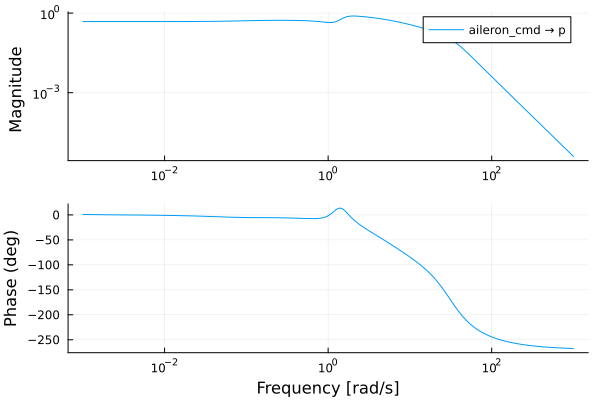

In [833]:
bodeplot(P_a2p)

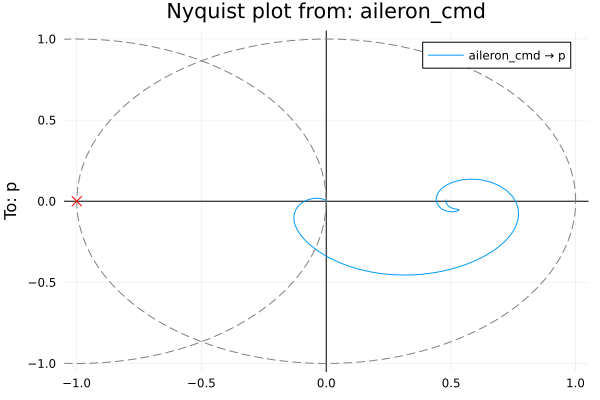

In [834]:
nyquistplot(P_a2p; unit_circle = true, Ms_circles = [1.0])
# plot!(ylims = (-2,2), xlims = (-2,2))

Because the open loop transfer function may be unstable, we cannot apply the final value theorem here. We will inspect the step response directly by simulation.

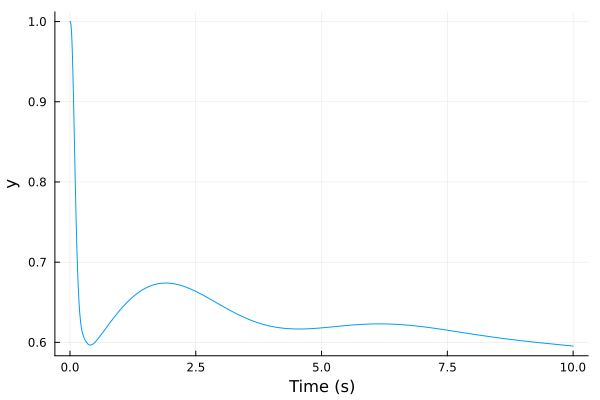

In [835]:
ε_a2p_cl = 1/(1+tf(P_a2p))
step(ε_a2p_cl, 10) |> plot

Even though the system potentially has an unstable and uncontrollable pole, we can still use PID optimization to get a useful result, in the sense of controlling the stable part of the sytem. Things to note:

- If the loop transfer function has unstable poles, one or more encirclements of (-1, 0) are required for it to be stable. Therefore, maintaining a minimum distance 1/|Ms| to (-1, 0) is no longer a guarantee of stability. However, it still is a useful metric for the short-term stability of the stable part of the system. 
- Both $\int{e}$ and $e_f$ will of course be infinite over a long enough time window, because no matter how diminished the influence of the unstable poles by corresponding zeros, they will cause divergence in the end. However, for a sufficiently small simulation time window, where their contribution is still negligible, the error metrics can still be minimized by the choice of PID parameters.

In [836]:
t_sim_p = 5
settings = PIDOpt.Settings(; t_sim = t_sim_p, maxeval = 5000)
weights = PIDOpt.Metrics(; Ms = 1, ∫e = 10, ef = 1, ∫u = 0, up = 0.0)
params_0 = PIDParams(; k_p = 1, k_i = 5, k_d = 0.01, τ_f = 0.01)
# params_0 = PIDParams()

p_results = PIDOpt.optimize_PID(P_a2p; params_0, settings, weights, global_search = false)
p_results.exit_flag |> display

@unpack k_p, k_i, k_d, T_i, T_d = p_results.params
@show k_p, k_i, k_d, T_i, T_d
@show p_results.metrics
@show p_results.cost

p_PID = PIDOpt.build_PID(p_results.params)
C_p2a = p_PID
C_p2a = named_ss(C_p2a, :pcmp; u = :p_err, y = :aileron_cmd);


:ROUNDOFF_LIMITED

(k_p, k_i, k_d, T_i, T_d) = (0.7538261843948643, 7.0053905827671565, 0.02585060753170811, 0.10760658888160095, 0.034292530648109214)
p_results.metrics = [1.09929193217148, 0.06746862740352519, 0.007803093119896021, 0.7516419083562484, 2.338886937565675]
p_results.cost = 0.14848177494388567


StepInfo:
Initial value:     0.000
Final value:       1.008
Step size:         1.008
Peak:              1.030
Peak time:         3.536 s
Overshoot:          2.19 %
Undershoot:         0.00 %
Settling time:     3.868 s
Rise time:         0.389 s


isstable(T_p) = false


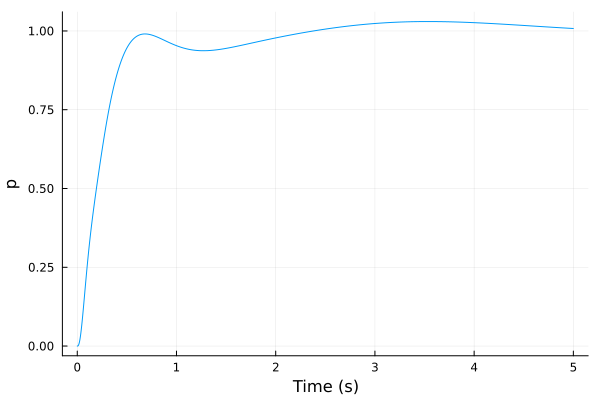

In [837]:
#we expect the roll rate-augmented closed loop system to remain unstable
@show isstable(T_p)

T_p = output_comp_sensitivity(P_a2p, C_p2a) #this is the closed loop transfer function
T_p_step = step(T_p, t_sim_p)
stepinfo(T_p_step) |> display
T_p_step |> plot

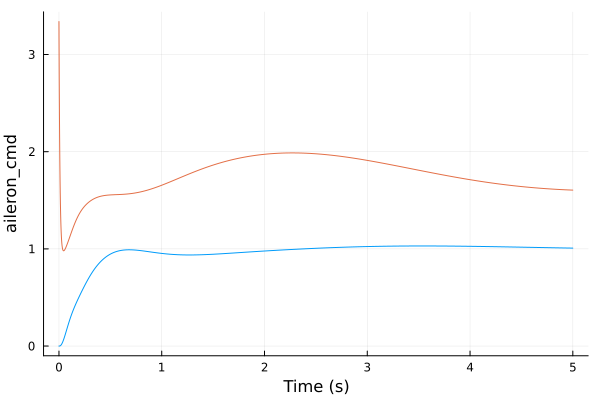

In [838]:
CS_p = G_CS(P_a2p, C_p2a)
CS_p_step = step(CS_p, t_sim_p)
CS_p_step |> plot!

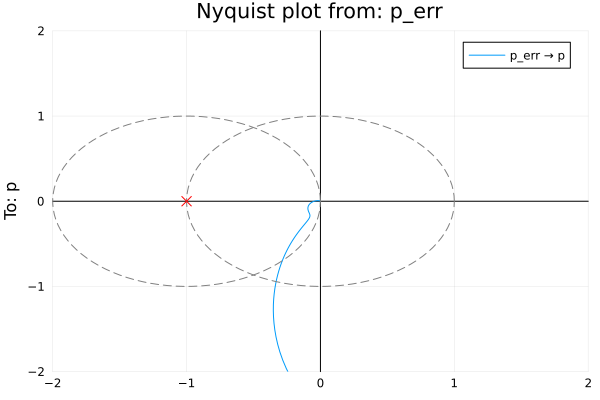

In [839]:
L_p = series(C_p2a, P_a2p)
nyquistplot(L_p; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

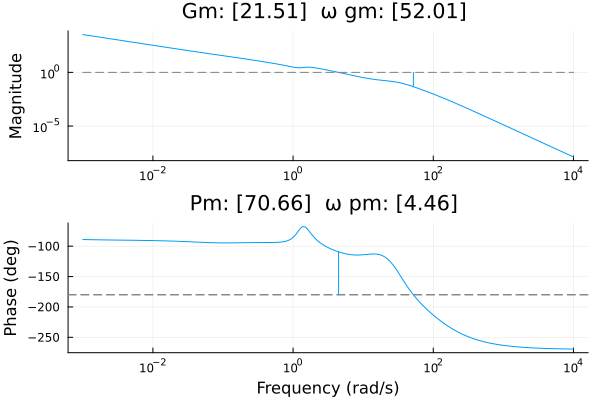

In [840]:
#like the Nyquist plot, the stability margins are not actually a guarantee in
#the presence of unstable poles, but it gives some insight about the
#minimum-phase part of the system
L_p = series(C_p2a, P_a2p)
marginplot(L_p)

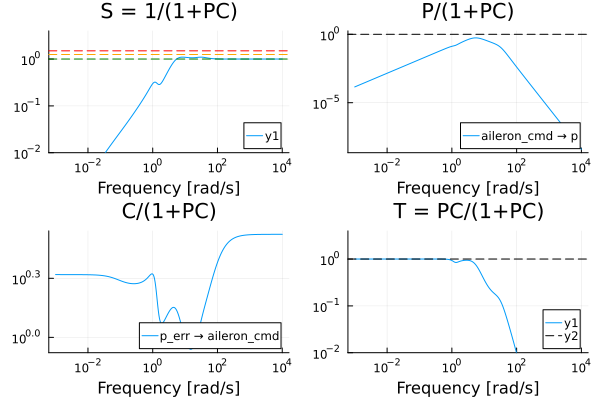

In [841]:
gangoffourplot(P_a2p, C_p2a)

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                      (1.0s^2 + 24.675291665407833s + 209.81215338410556)(1.0s^2 + 0.7183728117847621s + 1.5911324253514305)(1.0s + 0.6229965628393611)(1.0s - 0.08658681162468222)(1.0s + 1.1265658245281163e-7)
13232.244219112436--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 101.4562451947478)(1.0s^2 + 34.36055062649182s + 997.8645408907128)(1.0s^2 + 7.167274552886676s + 28.718634729587393)(1.0s + 0.6228529776287671)(1.0s^2 + 0.8095045708315731s + 1.514713883984081)(1.0s + 1.1265595909862825e-7)(1.0s - 0.08687202797884921)

Continuous-time transfer function model

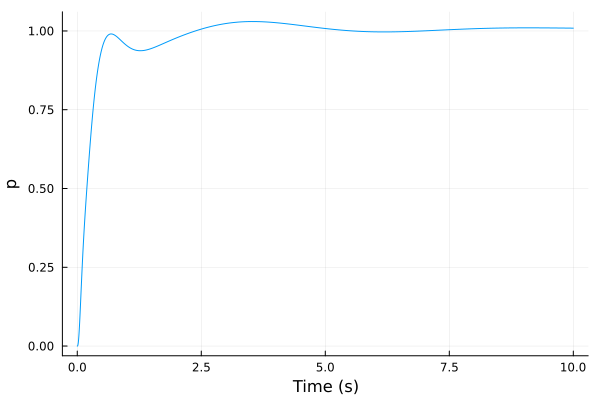

In [842]:
psum = sumblock("p_err = p_dmd - p")
p_rud_MIMO = connect([psum, C_p2a, ail_rud_MIMO], [:p_err=>:p_err, :p=>:p, :aileron_cmd=>:aileron_cmd], w1 = [:p_dmd, :rudder_cmd], z1 = ail_rud_MIMO.y)

#check we get the same response as with the SISO closed loop
pdmd2p = p_rud_MIMO[:p, :p_dmd]

#while the spiral mode still persists, its contribution to the
#roll response has basically been eliminated by a near cancellation
zpk(pdmd2p) |> display

step(pdmd2p, 2t_sim_p) |> plot


## 2. Bank Angle

In [843]:
P_p2φ = p_rud_MIMO[:φ, :p_dmd]
zpk(P_p2φ)

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                     (1.0s^2 + 24.675291665407897s + 209.81215338410578)(1.0s^2 + 0.5860082059659182s + 1.620940035649125)(1.0s + 0.6230435094765426)(1.0s + 5.770892315152272e-7)
13154.138590011826--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 101.4562451947478)(1.0s^2 + 34.36055062649182s + 997.8645408907128)(1.0s^2 + 7.167274552886676s + 28.718634729587393)(1.0s + 0.6228529776287671)(1.0s^2 + 0.8095045708315731s + 1.514713883984081)(1.0s + 1.1265595909862825e-7)(1.0s - 0.08687202797884921)

Continuous-time transfer function model

In [844]:
t_sim_φ = 10
upper_bounds = PIDParams(; k_p = 50.0, k_i = 10.0, k_d = 5.0, τ_f = 0.01) #disallow integral gain
settings = PIDOpt.Settings(; t_sim = t_sim_φ, maxeval = 5000, upper_bounds)
weights = PIDOpt.Metrics(; Ms = 1, ∫e = 10, ef = 1, ∫u = 0.01, up = 0.00)
params_0 = PIDParams(; k_p = 7., k_i = 0., k_d = 1.0, τ_f = 0.01)
# params_0 = PIDParams()
φ_results = PIDOpt.optimize_PID(P_p2φ; params_0, settings, weights, global_search = false)
φ_PID = PIDOpt.build_PID(φ_results.params)
C_φ2p = named_ss(φ_PID, :φcmp; u = :φ_err, y = :p_dmd);

@unpack k_p, k_i, k_d, T_i, T_d = φ_results.params
@show k_p, k_i, k_d, T_i, T_d
@show φ_results.metrics
@show φ_results.cost


(k_p, k_i, k_d, T_i, T_d) = (6.634713578313466, 1.293009907803088e-15, 1.395298975391844, 5.131216348980881e15, 0.2103028199970204)
φ_results.metrics = [1.218676095942078, 0.030838081422418447, 0.01052546443523461, 1.3075246264486686, 145.16461111749788]
φ_results.cost = 0.12911387351090622


0.12911387351090622

StepInfo:
Initial value:     0.000
Final value:       1.011
Step size:         1.011
Peak:              1.041
Peak time:         0.431 s
Overshoot:          3.00 %
Undershoot:         0.00 %
Settling time:     2.756 s
Rise time:         0.222 s


isstable(T_φ) = true


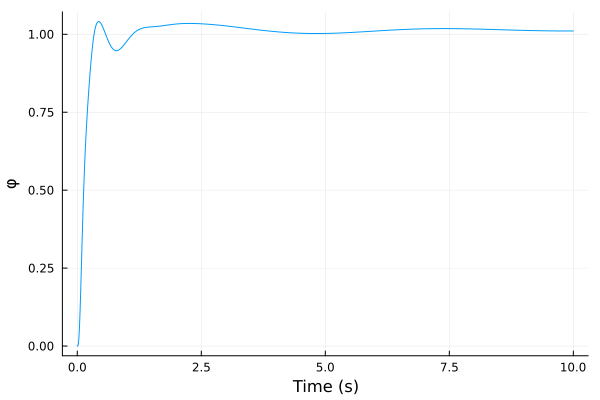

In [845]:
#we can see that bank angle feedback is enough to stabilize the spiral mode.
#this is all we need for automatic flight. roll rate
@show isstable(T_φ)


T_φ = output_comp_sensitivity(P_p2φ, C_φ2p) #this is the closed loop transfer function
T_φ_step = step(T_φ, t_sim_φ)
stepinfo(T_φ_step) |> display
T_φ_step |> plot


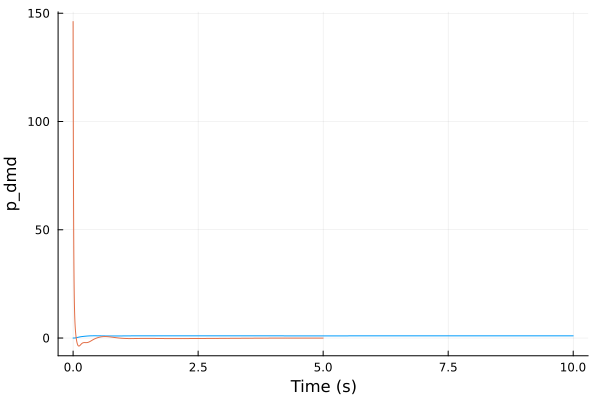

In [846]:
CS_φ = G_CS(P_p2φ, C_φ2p)
CS_φ_step = step(CS_φ, t_sim_p)
CS_φ_step |> plot!

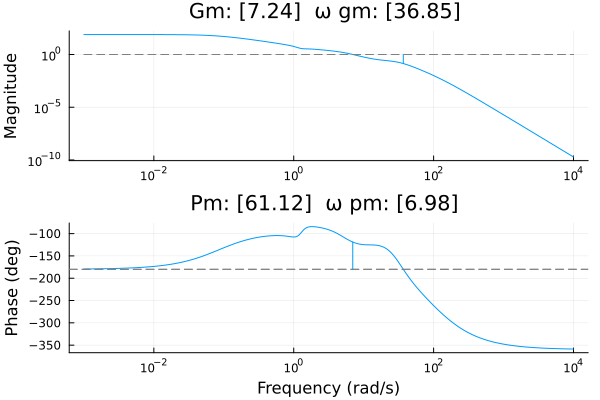

In [847]:
L_φ = series(C_φ2p, P_p2φ)
marginplot(L_φ)

In [848]:
zpk(T_φ) |> display
poles(T_φ) |> display
poles(minreal(T_φ, 1e-2)) |> display


TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                                      (1.0s^2 + 24.67529166540794s + 209.81215338410487)(1.0s + 4.539206534049387)(1.0s^2 + 0.5860082059659099s + 1.620940035649129)(1.0s + 0.6230435094765424)(1.0s + 1.9496846710147775e-16)(1.0s + 5.770892315158963e-7)
1.9226695515947505e6-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                    (1.0s^2 + 205.02579642056241s + 10694.870948404097)(1.0s^2 + 27.934358417990275s + 946.5518104507814)(1.0s^2 + 7.10897085153812s + 60.21299641975857)(1.0s + 3.081029377017487)(1.0s + 0.6230645153990818)(1.0s^2 + 0.5563358416042767s + 1.5600154994413398)(1.0s + 5.831519688297824e-7)(1

12-element Vector{ComplexF64}:
     -102.51289821028121 + 13.637325578449074im
     -102.51289821028121 - 13.637325578449074im
     -13.967179208995137 + 27.412947951553758im
     -13.967179208995137 - 27.412947951553758im
       -3.55448542576906 + 6.897726420912467im
       -3.55448542576906 - 6.897726420912467im
      -3.081029377017487 + 0.0im
    -0.27816792080213837 + 1.2176362787293893im
    -0.27816792080213837 - 1.2176362787293893im
     -0.6230645153990818 + 0.0im
   -5.831519688297824e-7 + 0.0im
 -1.9537688626954709e-16 + 0.0im

10-element Vector{ComplexF64}:
 -102.51289821138207 + 13.637325505413195im
 -102.51289821138207 - 13.637325505413195im
 -13.967179207731522 + 27.412947953956277im
 -13.967179207731522 - 27.412947953956277im
  -3.554485425943401 + 6.897726421102331im
  -3.554485425943401 - 6.897726421102331im
 -3.0810293772219643 + 0.0im
   -0.62306477489407 + 0.0im
 -0.2781678889863701 + 1.217636339725841im
 -0.2781678889863701 - 1.217636339725841im

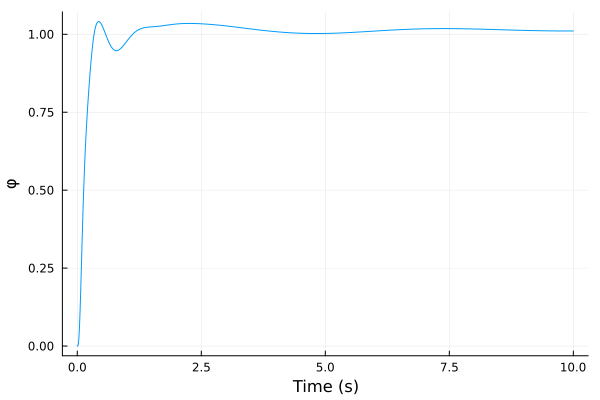

In [849]:
φsum = sumblock("φ_err = φ_dmd - φ")
φ_rud_MIMO = connect([φsum, C_φ2p, p_rud_MIMO], [:φ_err=>:φ_err, :φ=>:φ, :p_dmd=>:p_dmd], w1 = [:φ_dmd, :rudder_cmd], z1 = p_rud_MIMO.y)

#check we get the same response as with the SISO closed loop
φdmd2φ = φ_rud_MIMO[:φ, :φ_dmd]
step(φdmd2φ, t_sim_φ) |> plot

## 3. Course Angle

We start from the plant with embedded bank angle control.

In [850]:
P_φ2χ = φ_rud_MIMO[:χ, :φ_dmd]
P_φ2χ = minreal(P_φ2χ, 1e-2) #simplify pole-zero cancellations
zpk(P_φ2χ) |> display
isstable(P_φ2χ)

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                      (1.0s^2 + 24.675291665407915s + 209.81215338410627)(1.0s + 4.539206534049449)(1.0s^2 - 0.3864914233759603s + 14.145190232790728)(1.0s + 0.6230401652206982)(1.0s^2 + 0.47284548037975216s + 1.7484584922264312)
45076.60998232649------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s^2 + 205.02579642056216s + 10694.87094840406)(1.0s^2 + 27.934358417990282s + 946.5518104507826)(1.0s^2 + 7.108970851538338s + 60.21299641976095)(1.0s + 3.0810293770172845)(1.0s + 0.6230645153990814)(1.0s^2 + 0.5563358416042836s + 1.5600154994413427)(1.0s + 5.83151965844885e-7)

Continuous-time transfer function model

true

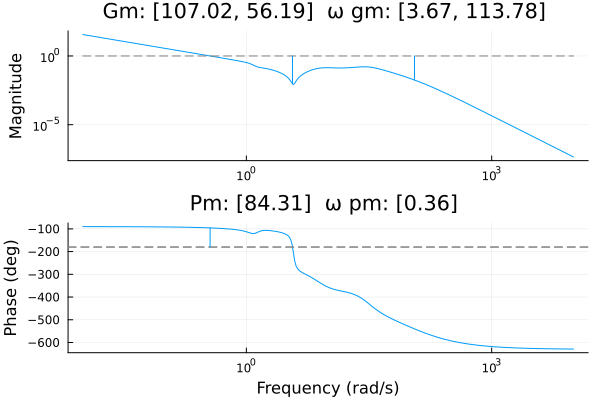

In [851]:
marginplot(P_φ2χ)

11-element Vector{ComplexF64}:
   -116.8932563226798 + 0.0im
   -84.03241725057518 + 0.0im
   -15.79298573554256 + 29.177579579806668im
   -15.79298573554256 - 29.177579579806668im
  -3.7097002833165655 + 6.514564652287869im
  -3.7097002833165655 - 6.514564652287869im
  -2.8537719704020748 + 0.0im
 -0.25815740182529656 + 1.2015732357117876im
 -0.25815740182529656 - 1.2015732357117876im
  -0.6231191052288282 + 0.0im
  -0.4053045170092255 + 0.0im

ε_φ2χ_cl(0) = [1.6091887897313764e-6;;]


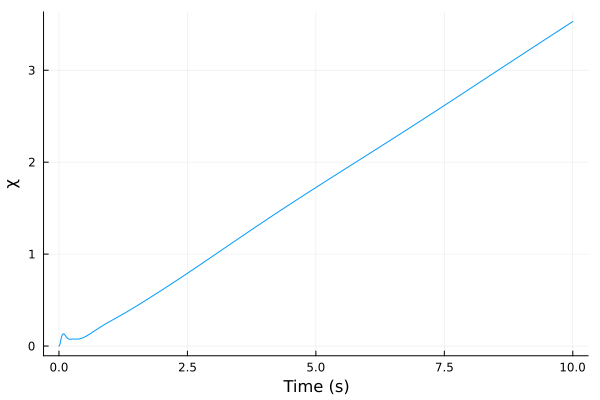

In [852]:
ɛ_φ2χ_cl = 1/(1+tf(P_φ2χ))
ɛ_φ2χ_cl |> poles |> display #all closed loop poles are stable
@show ɛ_φ2χ_cl(0) #steady state error is negligible
step(P_φ2χ, 10) |> plot

For the course angle, automatic PID optimization is not that useful. We can simply pick a set of gains that work well for a representative cruise condition and leave some stability margins for other airspeeds.

In [853]:
k_p_χ = 5
T_i_χ = 25
T_d_χ = 0.00
@show k_i_χ = k_p_χ / T_i_χ
@show k_d_χ = k_p_χ * T_d_χ
χ_PID = PIDOpt.build_PID(PIDParams(; k_p = k_p_χ, k_i = k_i_χ, k_d = k_d_χ))
C_χ2φ = named_ss(χ_PID, :χcmp; u = :χ_err, y = :φ_dmd);

k_i_χ = k_p_χ / T_i_χ = 0.2
k_d_χ = k_p_χ * T_d_χ = 0.0


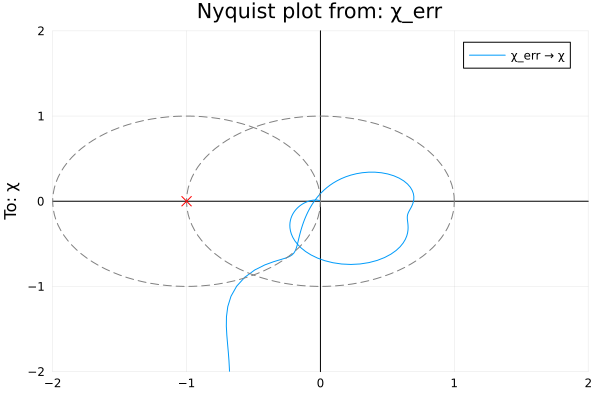

In [854]:
L_χ = series(C_χ2φ, P_φ2χ)
nyquistplot(L_χ, unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

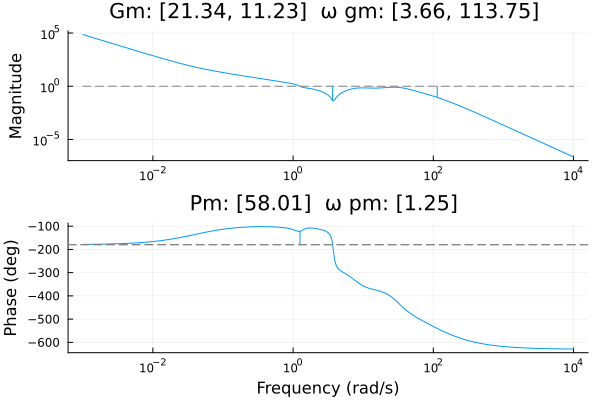

In [855]:
marginplot(L_χ)

Here we are particularly interested in the load disturbance to output transfer function P/(1+C). In order for the controller to be able to counter the effects of crosswind, this function needs to show low frequency attenuation.

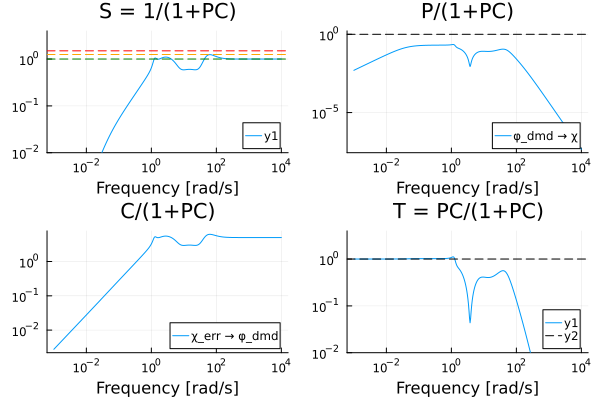

In [856]:
gangoffourplot(P_φ2χ, C_χ2φ)

For the step response it is important to consider the input to control signal response, because obviously our bank angle demand will be limited

StepInfo:
Initial value:     0.000
Final value:       1.008
Step size:         1.008
Peak:              1.102
Peak time:         2.479 s
Overshoot:          9.31 %
Undershoot:         0.00 %
Settling time:     8.669 s
Rise time:         1.220 s


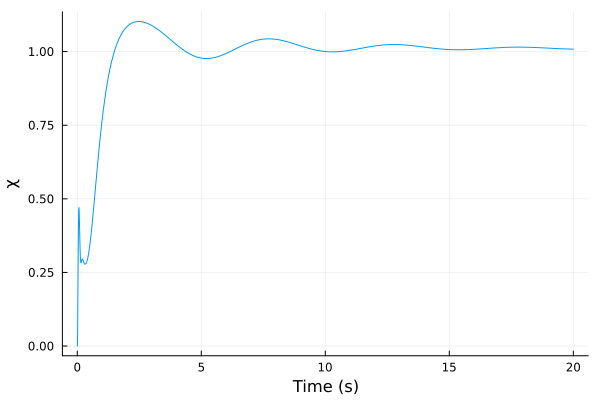

In [857]:
t_sim_χ = 20
T_χ = output_comp_sensitivity(P_φ2χ, C_χ2φ) #input to output response
T_χ_step = step(T_χ, t_sim_χ)
stepinfo(T_χ_step) |> display
T_χ_step |> plot

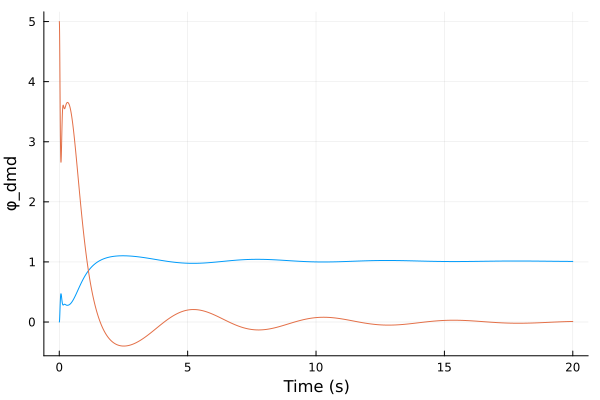

In [858]:
CS_χ = G_CS(P_φ2χ, C_χ2φ) #input to control signal response
CS_χ_step = step(CS_χ, t_sim_χ)
CS_χ_step |> plot!

## Tests

In [859]:
P_a2p = ail_rud_MIMO[:p, :aileron_cmd]
P_a2r = ail_rud_MIMO[:r, :aileron_cmd]
P_a2β = ail_rud_MIMO[:β, :aileron_cmd]
P_a2fy = ail_rud_MIMO[:f_y, :aileron_cmd]

P_r2p = ail_rud_MIMO[:p, :rudder_cmd]
P_r2r = ail_rud_MIMO[:r, :rudder_cmd]
P_r2β = ail_rud_MIMO[:β, :rudder_cmd]
P_r2fy = ail_rud_MIMO[:f_y, :rudder_cmd]

# step(P_a2p, 5) |> plot
# step(P_a2r, 5) |> plot
# step(P_a2β, 5) |> plot

# step(P_r2p, 5) |> plot
# step(P_r2r, 5) |> plot
# step(P_r2fy, 5) |> plot
# step(P_r2β, 5) |> plot

NamedStateSpace{Continuous, Float64}
A = 
 -5.1863353105447745       2.5571504706211035   -1.4940496395721148e-5   -8.412643903721317e-8    0.021208552272927967    -0.20927207299819522      0.0                 0.0                  4.015429907016977      0.0                 -0.3593450108796908
 -0.10965700655715027     -0.6145184249254187    2.7868529475227888e-6   -2.242321214485088e-6    0.0022260644798630515    0.06398864887796041      0.0                 0.0                 -0.09629816687604409    0.0                  0.3613947924611671
  1.0                      0.2461249217794798   -6.822997012730885e-9     2.8548808637156386e-8   1.602621845881149e-18   -1.6143782896245511e-7    0.0                 0.0                  0.0                    0.0                  0.0
  0.0                      1.0298367984946242   -4.023279493220938e-6     6.822996860046383e-9    6.705696269384723e-18   -3.8582689039415235e-8    0.0                 0.0                  0.0                    0.0  

In [860]:
#these are rudder step tests with roll rate control active
P_r2p_2 = p_rud_MIMO[:p, :rudder_cmd]
P_r2r_2= p_rud_MIMO[:r, :rudder_cmd]
P_r2β_2= p_rud_MIMO[:β, :rudder_cmd]
P_r2fy_2 = p_rud_MIMO[:f_y, :rudder_cmd]

# step(P_r2p_2, 5) |> plot
# step(P_r2r_2, 5) |> plot
# step(P_r2β_2, 5) |> plot
# step(P_r2fy_2, 5) |> plot

NamedStateSpace{Continuous, Float64}
A = 
    0.0                         8.0                   0.0                      0.0                   0.0                      0.0                     0.0                     0.0                      0.0                  0.0                    0.0                  0.0
   -4.860966200925213e-15     -99.99999999999999    -15.999999999999998        0.0                   0.0                      0.0                     0.0                     0.0                      0.0                  0.0                    0.0                  0.0
    0.0                         0.0                  -5.1863353105447745       2.5571504706211035   -1.4940496395721148e-5   -8.412643903721317e-8    0.021208552272927967   -0.20927207299819522      0.0                  4.015429907016977      0.0                 -0.3593450108796908
    0.0                         0.0                  -0.10965700655715027     -0.6145184249254187    2.7868529475227888e-6   -2.24232121448